# NEED TO TAKE CARE OF UNKNWON VALUES BEFORE ALL THIS

Cluster 0 most common crimes:
ofns_desc
CRIMINAL MISCHIEF & RELATED OF    3825
GRAND LARCENY                     3029
OFF. AGNST PUB ORD SENSBLTY &     1554
Name: count, dtype: int64
Cluster 1 most common crimes:
ofns_desc
HARRASSMENT 2                   5139
ASSAULT 3 & RELATED OFFENSES    3707
Name: count, dtype: int64
Cluster 2 most common crimes:
ofns_desc
PETIT LARCENY    6249
Name: count, dtype: int64
Cluster 3 most common crimes:
ofns_desc
FELONY ASSAULT    1370
Name: count, dtype: int64
Cluster 4 most common crimes:
ofns_desc
ROBBERY    893
Name: count, dtype: int64


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
import folium

# Load data
df = pd.read_csv('NYPD_Complaint_Data_YTD.csv')

# Clean data
df = df.dropna(subset=['lat_lon.latitude', 'lat_lon.longitude', 'ofns_desc'])
crime_types = df['ofns_desc'].unique()

# Step 1: Divide NYC into geographic clusters
coords = df[['lat_lon.latitude', 'lat_lon.longitude']].values
kmeans = KMeans(n_clusters=20, random_state=42)  # 20 zones
df['zone'] = kmeans.fit_predict(coords)

# Step 2: Find dominant crime per zone
zone_crimes = df.groupby(['zone', 'ofns_desc']).size().unstack().fillna(0)
df['dominant_crime'] = zone_crimes.idxmax(axis=1)[df['zone']].values

# Step 3: Create a lookup function
def get_crime_zone(lat, lon):
    point = [[lat, lon]]
    zone = kmeans.predict(point)[0]
    return {
        'zone': zone,
        'dominant_crime': zone_crimes.idxmax(axis=1)[zone],
        'common_crimes': zone_crimes.loc[zone].nlargest(3).to_dict()
    }

# Test with Times Square
print(get_crime_zone(40.7580, -73.9855))

{'zone': 8, 'dominant_crime': 'PETIT LARCENY', 'common_crimes': {'PETIT LARCENY': 975.0, 'GRAND LARCENY': 693.0, 'HARRASSMENT 2': 377.0}}


In [6]:
# Create an interactive map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Color coding for crime types
crime_colors = {
    'THEFT': 'red',
    'ASSAULT': 'blue',
    'DRUGS': 'green',
    'BURGLARY': 'orange',
    'OTHER': 'gray'
}

# Add zone boundaries
for zone in range(20):
    zone_data = df[df['zone'] == zone]
    folium.Polygon(
        locations=zone_data[['lat_lon.latitude', 'lat_lon.longitude']].values,
        color=crime_colors.get(zone_data['dominant_crime'].iloc[0], 'gray'),
        fill=True,
        popup=f"Zone {zone}: {zone_data['dominant_crime'].iloc[0]}"
    ).add_to(m)

m.save('nyc_crime_type_zones.html')

All unique raw race values in dataset:
|                                |   count |
|:-------------------------------|--------:|
| WHITE HISPANIC                 |       1 |
| UNKNOWN                        |       1 |
| BLACK                          |       1 |
| BLACK HISPANIC                 |       1 |
| AMERICAN INDIAN/ALASKAN NATIVE |       1 |
| WHITE                          |       1 |
| ASIAN / PACIFIC ISLANDER       |       1 |

Standardized race categories:
| vic_race_standardized   |   count |
|:------------------------|--------:|
| UNKNOWN                 |   11027 |
| BLACK                   |    8232 |
| WHITE HISPANIC          |    5634 |
| WHITE                   |    5243 |
| ASIAN                   |    2566 |
| BLACK HISPANIC          |    1250 |


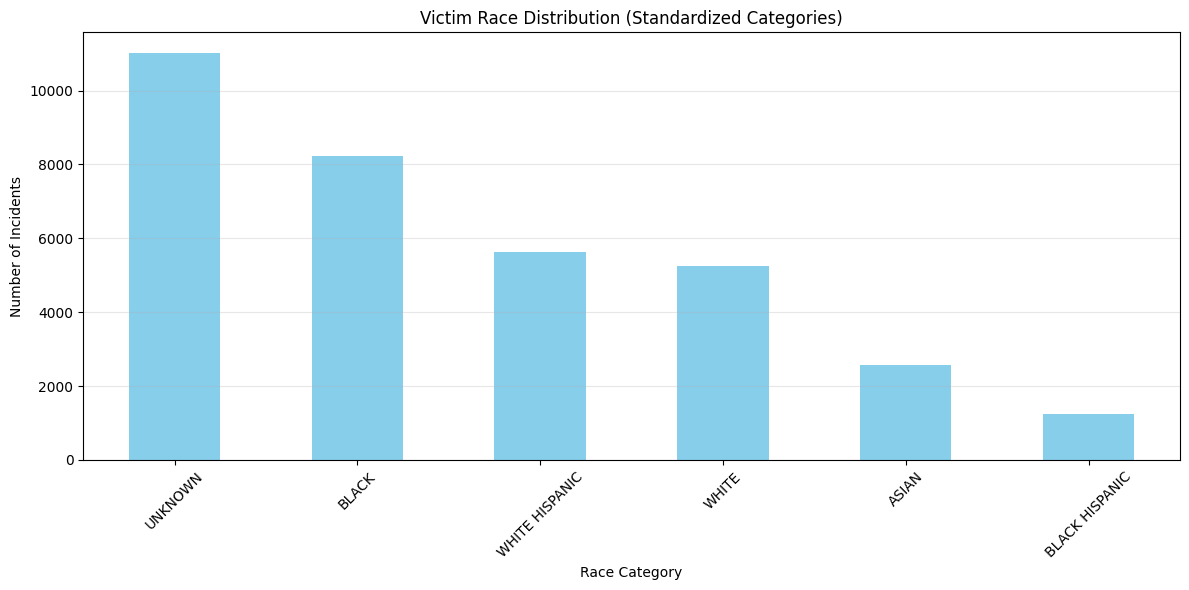

In [8]:
# RACE
import pandas as pd

# Load the data
df = pd.read_csv('NYPD_Complaint_Data_YTD.csv')

# Check the column name for victim race (handle different possible column names)
victim_race_col = [col for col in df.columns if 'race' in col.lower() and ('vic' in col.lower() or 'victim' in col.lower())][0]

# Get all unique race values
raw_races = df[victim_race_col].unique()
print("All unique raw race values in dataset:")
print(pd.Series(raw_races).value_counts().to_markdown())

# Standardize the race categories
def standardize_race(race):
    race = str(race).upper().strip()
    
    if pd.isna(race) or race in ['UNKNOWN', 'UNSPECIFIED', 'N/A', '']:
        return 'UNKNOWN'
    elif 'WHITE' in race and 'HISPANIC' in race:
        return 'WHITE HISPANIC'
    elif 'WHITE' in race:
        return 'WHITE'
    elif 'BLACK' in race and 'HISPANIC' in race:
        return 'BLACK HISPANIC'
    elif 'BLACK' in race or 'AFRICAN' in race:
        return 'BLACK'
    elif 'ASIAN' in race or 'CHINESE' in race or 'INDIAN' in race:
        return 'ASIAN'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'HISPANIC'
    else:
        return 'OTHER'

df['vic_race_standardized'] = df[victim_race_col].apply(standardize_race)

# Show standardized distribution
print("\nStandardized race categories:")
print(df['vic_race_standardized'].value_counts().to_markdown())

# Optional: Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['vic_race_standardized'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Victim Race Distribution (Standardized Categories)')
plt.xlabel('Race Category')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from collections import Counter

# Load and clean data
df = pd.read_csv('NYPD_Complaint_Data_YTD.csv')
df = df.dropna(subset=['lat_lon.latitude', 'lat_lon.longitude', 'vic_race'])

# Step 1: Standardize race categories
race_mapping = {
    'WHITE': ['WHITE', 'WHITE HISPANIC'],
    'BLACK': ['BLACK', 'BLACK HISPANIC'],
    'ASIAN': ['ASIAN', 'CHINESE', 'KOREAN'],
    'OTHER': ['OTHER', 'UNKNOWN']
}

def standardize_race(race):
    race = str(race).upper()
    for std_race, variants in race_mapping.items():
        if any(v in race for v in variants):
            return std_race
    return 'OTHER'

df['vic_race_std'] = df['vic_race'].apply(standardize_race)

# Step 2: Create race-weighted geographic clusters
race_dummies = pd.get_dummies(df['vic_race_std'])
geo_race_data = pd.concat([
    df[['lat_lon.latitude', 'lat_lon.longitude']],
    race_dummies
], axis=1)

# Normalize features
geo_race_data = (geo_race_data - geo_race_data.mean()) / geo_race_data.std()

# Cluster (20 zones)
kmeans_race = KMeans(n_clusters=20, random_state=42)
df['race_zone'] = kmeans_race.fit_predict(geo_race_data)

# Step 3: Identify racial patterns per zone
def get_top_races(zone_df):
    races = zone_df['vic_race_std'].value_counts(normalize=True)
    return races[races > 0.2].to_dict()  # Only include races with >20% presence

zone_races = df.groupby('race_zone').apply(get_top_races)

# Step 4: Create lookup function
def get_race_zone(lat, lon):
    point = [[lat, lon]]
    zone = kmeans_race.predict(point)[0]
    return {
        'zone': zone,
        'racial_composition': zone_races[zone],
        'sample_size': len(df[df['race_zone'] == zone])
    }

# Test with Harlem coordinates
print(get_race_zone(40.8116, -73.9465))